<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Experiment with Customer Segmentation using and open-source LLMs on AI Unlimited
  <br>
       <img id="teradata-logo" src="https://raw.githubusercontent.com/Teradata/lake-demos/8c77e9297e8f3059921aee472fc0ae30ae0537db/images/TeradataLogo.png" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>
<hr>

<br>

<b style = 'font-size:24px;font-family:Arial;color:#00233C'>Leverage highly-scalable native processing functions to experiment with ideal customer segments using word embeddings and clustering algorithms</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Vector embedding</b> is a numerical representation of data that captures semantic relationships and similarities, making it possible to perform mathematical operations and comparisons on the data for various tasks like text analysis and recommendation systems.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>K-means clustering</b> is one of the most popular <b>unsupervised</b> machine learning algorithms.  Essentially, the algorithm seeks to group similar data points together by minimizing the average ("means" in K-means) distance for all data points from each cluster's center (centroid).</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Using <b>Teradata AI Unlimited</b> and <b>ClearScape Analytics</b>, users can experiment with advanced AI and ML techniques to <b>rapidly</b> find the ideal number of customer segments based on the semantic meaning of their comments history.  This segmentation can be used on its own for marketing and other tasts, or used in further predictive analytics use cases.</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Create a Vector Embedding table using open-source LLMs against customer comments data, using the <b>AI Unlimited</b> Engine</li>
                <br>
                <li>Execute multiple experiments <b>in parallel</b>, leveraging the highly-scalable nature of the platform</li>
                <br>
                <li>Visualize the experimental results to indicate the best cluster.</li>
            </ol>
        </td>
        <td><img src = 'https://raw.githubusercontent.com/Teradata/lake-demos/8c77e9297e8f3059921aee472fc0ae30ae0537db/UseCases/Vector-Embeddings-Segmentation/images/comparative_superlative_small.jpg' width = '250'></td>
        <td><img src = 'https://raw.githubusercontent.com/Teradata/lake-demos/8c77e9297e8f3059921aee472fc0ae30ae0537db/UseCases/Vector-Embeddings-Segmentation/images/K-means_convergence.gif' width = '250'></td>
    </tr>
</table>

<hr>

In [1]:
%connect unlimited

Success: 'unlimited' connection established and activated for user 'tduser', with default database 'unlimited'


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 0 - Access and inspect data</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Teradata AI Unlimited can transparently <b>read</b> and <b>write</b> data from various third-party catalogs such as <b>AWS Glue</b>, <b>Azure OneLake</b>, etc.  To access this data, perform the following</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Create an Authorization object for secured access</li>
    <li>create a "DATALAKE" object that points to the catalog</li>
    <li>Use SQL syntax to inspect the catalog, database, and table metadata</li>
    </ol>
    

In [17]:
/*First, we'll create an authorization to establish the credendials for AWS resources */
REPLACE AUTHORIZATION unlimited.glue_auth_aws
USER 'EXAMPLE'
PASSWORD 'EXAMPLE';

Success: 1 rows affected

In [18]:
/*Second we create the connectivity to the Iceberg Glue Data Lake*/

REPLACE DATALAKE aws_glue_catalog
EXTERNAL SECURITY CATALOG unlimited.glue_auth_aws,
EXTERNAL SECURITY STORAGE unlimited.glue_auth_aws
USING
catalog_type ('glue')
storage_region ('us-west-2')
TABLE FORMAT iceberg;

Success: 0 rows affected

In [19]:
HELP DATALAKE aws_glue_catalog;

,DatabaseName,DatabaseProperties
1,default,
2,tddemos_glue_db,'location'='s3://kmstddemobucket/glue-db/'


In [20]:
HELP DATABASE aws_glue_catalog.tddemos_glue_db;

,TableName,TableProperties
1,customer_journey,
2,glove_6b_50d,
3,retail_events,
4,uk_retail_data,
5,web_comment,


In [21]:
HELP TABLE aws_glue_catalog.tddemos_glue_db.web_comment;

,ColumnName,IcebergType,TeradataType
1,comment_id,int,INTEGER_DT
2,customer_id,int,INTEGER_DT
3,comment_text,string,VARCHAR_DT(32000) CHARACTER SET UNICODE
4,comment_summary,string,VARCHAR_DT(32000) CHARACTER SET UNICODE


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 1 - Data Preparation using an LLM to create a Vector Table</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we will inspect the original data set, and use native vector embedding functions to generate features.  This data has been pre-loaded in an AWS Glue catalog.  Users can access this data transparently using multi-dot notation.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Inspect the rows of the Customer Comments table</li>
    <li>Inspect the GloVe Model table</li>
    <li>Use TD_WordEmbeddings function to create the vector table</li>
    </ol>
    

<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>1.1 - Inspect the Data</b>

<p style = 'font-size:16px;font-family:Arialcolor:#00233C'>Display a sample</p>

In [22]:
SELECT * FROM aws_glue_catalog.tddemos_glue_db.web_comment
SAMPLE 2;

,comment_id,customer_id,comment_text,comment_summary
1,10417,1056,Beautiful emerald green color in a lovely silk. i suggest one size down if you're small chested as the arm holes will fit more snugly.,"Flattering, great material"
2,14143,1059,These pants run large than the true size. it is so comfortable and can be dress up or dressed down.,Comfy


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233'>1.2 - Model table</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We format the model table as in the documentation: a column for the token, and a column for each dimension of the vector space. This example uses the GloVe 50-dimensional pre-trained embeddings. For more information on this model, see the Stanford University Publication <a href = 'https://nlp.stanford.edu/projects/glove/'>"GloVe: Global Vectors for Word Representation"</a></p>

In [23]:
SELECT * FROM aws_glue_catalog.tddemos_glue_db.glove_6B_50d
SAMPLE 2;

,doc_id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50
1,silaen,0.082545,-0.36383,0.74457,1.0625,1.2283,-0.4362,0.51992,0.23632,0.13507,-0.90665,-0.10654,-0.38325,-0.82213,-0.25985,0.18952,0.82462,0.63599,0.42625,0.3898,0.0080457,-0.44562,0.88563,-0.59781,0.86375,0.078257,0.4904,0.93551,0.039168,-0.11109,0.89151,-2.2281,-0.31995,0.78832,-1.2153,0.7921,-0.014314,0.035021,-0.3444,-1.5552,0.43403,-0.5441,0.99277,-0.10271,0.020174,-0.12116,0.095792,-0.62141,-0.22868,-0.13246,0.21624
2,143-pound,0.96483,-0.22827,0.045749,0.021639,-0.64778,0.27905,1.6029,-0.0022231,0.11469,-0.53615,0.020877,0.50026,0.3769,1.1131,-0.28033,-0.64019,-0.45122,0.54366,-0.10348,0.22105,-1.1698,-0.2824,0.47,0.92844,-0.16603,1.2557,0.17624,0.13949,-0.90158,0.093666,-1.3108,0.025285,-0.8227,0.9567,-0.97186,-0.10242,-0.27784,-1.1932,0.063748,-1.4032,1.2044,-1.0754,0.501,0.42923,-0.030509,-0.28465,1.4534,0.50535,0.36449,0.26441


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>1.4 - Embeddings</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>TD_WordEmbeddings can perform four operations: token-embedding, doc-embedding, token2token-similarity, and doc2doc-similarity. This notebook shows the first two.  We will use doc-embedding as the basis for our Segmentation.</p>

In [24]:
WITH comments_data AS (
    SELECT comment_id, customer_id, TRANSLATE(comment_text USING UNICODE_TO_LATIN) comment_text
    FROM aws_glue_catalog.tddemos_glue_db.web_comment),

model_data AS (
    SELECT TRANSLATE(doc_id USING UNICODE_TO_LATIN) doc_id, 
            v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, 
            v11, v12, v13, v14, v15, v16, v17, v18, v19, v20, 
            v21, v22, v23, v24, v25, v26, v27, v28, v29, v30, 
            v31, v32, v33, v34, v35, v36, v37, v38, v39, v40, 
            v41, v42, v43, v44, v45, v46, v47, v48, v49, v50
    FROM aws_glue_catalog.tddemos_glue_db.glove_6B_50d)
    

SELECT TOP 5 * FROM TD_WordEmbeddings (
    ON (SELECT TOP 1 * FROM comments_data) AS InputTable
    ON model_data AS ModelTable DIMENSION
USING
    IDColumn('comment_id')
    ModelVectorColumns('[1:49]')
    PrimaryColumn('comment_text')
    Operation('token-embedding')
    ModelTextColumn('doc_id')
)AS dt 
ORDER BY comment_id ASC;


,comment_id,TD_Token,TD_TokenCount,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49
1,2514,when,1,0.27062,-0.36596,0.097193,-0.50708,0.37375,0.16736,-0.94185,0.54004,-0.66669,-0.24236,0.25876,0.28084,-0.86643,-0.068961,0.90346,0.40877,-0.39563,-0.25604,-1.0316,-0.26669,-0.080584,0.40841,0.55885,-0.18299,0.46494,-2.2671,0.14102,0.19841,0.5153,-0.27608,3.3604,0.15123,-0.36693,-0.28804,0.076042,-0.076662,0.21897,0.39001,0.38684,-0.16961,-0.33674,0.37094,-0.45911,0.00066285,-0.17797,0.12467,-0.015418,-0.75256,-0.17335
2,2514,tights,1,-0.99142,0.14363,-1.3877,-0.23847,-0.76427,0.45943,0.75329,-0.89495,-0.3984,-0.53265,0.35955,0.69162,-0.10869,0.35505,0.10469,-0.19865,-0.64087,0.51274,0.082448,-1.5517,-1.1947,0.41159,0.59033,-0.53552,-1.1531,-0.30728,-0.31218,1.6781,0.75091,-0.97976,-0.11061,0.85961,-0.29375,-0.023124,-0.18971,0.47538,-0.42533,0.10601,-0.43828,-0.92775,-0.37455,0.12726,1.148,0.24331,-0.085167,-0.90322,0.56011,-1.5436,-0.37808
3,2514,short,1,0.08226,0.52026,-0.13314,-0.78449,-0.2366,0.58779,-0.4191,-0.39373,0.054773,0.012971,-0.62161,0.23175,-0.43722,0.499,0.39791,-0.28424,-0.051524,-0.32952,-0.88485,-0.35463,0.20174,-0.1279,0.61101,-0.31412,0.40172,-1.2991,-0.072569,0.61494,0.21407,0.032626,3.4835,-0.11963,0.45864,0.47906,0.22729,0.022899,0.22242,0.53241,-0.86963,-0.45325,-0.19527,0.35825,-0.08619,-0.0019633,-0.40885,-0.43347,0.66171,-0.022696,-0.34519
4,2514,realized,1,0.53254,-0.34176,0.12317,-0.61073,0.73907,-0.11109,-0.54485,0.24482,-0.42056,0.34463,0.30947,0.44566,-0.5861,-0.38819,0.6012,0.29977,0.16197,0.29134,0.054657,-0.40332,0.083921,0.49233,0.13737,-0.45364,1.2007,-0.96364,-0.90241,0.041135,0.6141,-0.45992,1.8644,0.30007,0.25469,-0.65912,-0.16737,-0.29478,-0.12876,0.49508,0.11654,-0.11719,-0.5576,-0.42194,-0.11729,0.11402,-0.33748,-0.33959,-0.1053,-0.068361,-0.23601
5,2514,isn't,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
WITH comments_data AS (
    SELECT TOP 1000 comment_id, customer_id, TRANSLATE(comment_text USING UNICODE_TO_LATIN) comment_text
    FROM aws_glue_catalog.tddemos_glue_db.web_comment),

model_data AS (
    SELECT TRANSLATE(doc_id USING UNICODE_TO_LATIN) doc_id, v1, v2, v3, v4
            v5, v6, v7, v8, v9, v10,
            v11, v12, v13, v14, v15,
            v16, v17, v18, v19, v20,
            v21, v22, v23, v24, v25,
            v26, v27, v28, v29, v30,
            v31, v32, v33, v34, v35,
            v36, v37, v38, v39, v40,
            v41, v42, v43, v44, v45,
            v46, v47, v48, v49, v50
    FROM aws_glue_catalog.tddemos_glue_db.glove_6B_50d)

SELECT TOP 2 * FROM TD_WordEmbeddings (
    ON comments_data AS InputTable
    ON model_data AS ModelTable DIMENSION
USING
    IDColumn('comment_id')
    ModelVectorColumns('[1:49]')
    PrimaryColumn('comment_text')
    Operation('doc-embedding')
    ModelTextColumn('doc_id')
    Accumulate('comment_text', 'customer_id')
)AS dt 
ORDER BY comment_id ASC;

,comment_id,v1,v2,v3,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,comment_text,customer_id
1,44,0.2343262672857143,0.07473221428571428,-0.09502094285714285,-0.17558378571428568,0.03932564285714289,-0.49589003000000015,-0.2041192099999999,-0.14350291157142855,-0.07354126328571428,-0.004745609999999996,-8.041571428572734e-05,-0.2878857857142857,-0.034937271428571434,0.2902968842857142,0.28960175714285713,0.009764999999999998,-0.02667304285714286,-0.22735000857142854,-0.5640309142857145,0.0035895285714286143,0.1251727485714286,0.12209477142857142,0.09261665142857144,0.024318899999999977,-1.4543639400000001,-0.48057251285714286,0.31533762857142855,0.2992247857142856,-0.32980491428571423,3.164413085714285,0.18699683571428571,-0.13854398571428572,-0.1377276028571429,0.10516553299999999,-0.014946267142857133,0.03715514714285714,0.2525842514285714,-0.004019678571428566,-0.28065471428571437,-0.055274000000000004,0.0910200971428571,0.01763180000000001,0.20138086371428568,-0.049329283571428545,0.019906448571428557,-0.0322223585714286,-0.20318200285714288,0.016424224285714283,-0.014694861428571456,"Tried this on today at my local retailer and had to have it. it is so comfortable and flattering. it's too bad the picture online has the model tucking it into the skirt because you can't see the ruching across the front. a little dressier alternative to a plain tee and reasonably priced for retailer. 5'8"""" and i generally wear a 6, the small fit well. will probably be back for the black!",862
2,136,0.056143110975609756,0.258226524390244,-0.21383385365853658,-0.15374898780487806,0.24009104024390243,-0.4102909158536584,-0.2862854853658535,-0.15451890426829268,-0.010160940609756098,-0.010200756097560977,0.04074521951219513,-0.26301206097560975,0.03634027195121949,0.32674551829268283,0.22266943658536584,0.09247281219512196,0.020666048902439033,-0.3179360975609755,-0.6374541463414632,-0.24979352439024394,0.20848721219512192,0.15520077926829268,-0.1075167256097561,0.07782286585365854,-1.4862170243902442,-0.5769914500000002,0.5085495609756097,0.43977561829268264,-0.2941979512195122,3.102396634146341,0.1186908109756098,-0.12603423536585368,-0.08277092926829267,0.08937849573170735,0.025075894024390262,-0.02093087804878049,0.2744250999999999,0.012012490243902456,-0.4228723170731706,-0.08268208170731704,0.1644130975609756,0.004756717073170743,0.13722630073170733,0.0012754146341463423,0.013822723170731695,0.009516993170731701,-0.2573501292682928,-0.009868249999999999,0.03205921097560975,"Love this vest! the color looks a little more brown in the picture than it really is--it's a deep forest green that goes great with jeans or black pants. a great piece for polished but casual style, and the fabric has a nice, soft suede-like finish. if only the was *slightly* higher to hit my true natural waist, it would get that fifth star (but sometimes i wear petite sizes, so that might be the issue here--still looks good tied).",966


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>1.4 - Materialize the data</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Materialize the embeddings to a local temporary table for consistency and performance - no need to re-embed each experiment.</p>

In [ ]:
/*Drop the table if necessary.  We are using volatile tables, 
so this shouldn't be necessary unless we rerun this in the same session */
DROP TABLE embedded_data

In [26]:
CREATE MULTISET VOLATILE TABLE embedded_data AS(
    WITH comments_data AS (
        SELECT TOP 1000 comment_id, customer_id, TRANSLATE(comment_text USING UNICODE_TO_LATIN) comment_text
        FROM aws_glue_catalog.tddemos_glue_db.web_comment),
    
    model_data AS (
        SELECT TRANSLATE(doc_id USING UNICODE_TO_LATIN) doc_id, v1, v2, v3, v4
                v5, v6, v7, v8, v9, v10,
                v11, v12, v13, v14, v15,
                v16, v17, v18, v19, v20,
                v21, v22, v23, v24, v25,
                v26, v27, v28, v29, v30,
                v31, v32, v33, v34, v35,
                v36, v37, v38, v39, v40,
                v41, v42, v43, v44, v45,
                v46, v47, v48, v49, v50
        FROM aws_glue_catalog.tddemos_glue_db.glove_6B_50d)
    
    SELECT * FROM TD_WordEmbeddings (
        ON comments_data AS InputTable
        ON model_data AS ModelTable DIMENSION
    USING
        IDColumn('comment_id')
        ModelVectorColumns('[1:49]')
        PrimaryColumn('comment_text')
        Operation('doc-embedding')
        ModelTextColumn('doc_id')
        Accumulate('comment_text', 'customer_id')
    )AS dt 
)WITH DATA
NO PRIMARY INDEX
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 2 - Find the Ideal K-means Model</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As discussed above, the K-means algorithm takes a number of clusters "k", chooses a random starting point for each centroid, and iterates until a hard limit or an optimium value is reached.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Other Function Parameters Include (but are not limited to)</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Input data - table, view, query</li>
    <li>StopThreshold - The algorithm converges if the distance between the centroids from the previous iteration and the current iteration is less than the specified value.</li>
    <li>MaxIterNum</li>Specify the maximum number of iterations for the K-means algorithm. The algorithm stops after performing the specified number of iterations even if the convergence criterion is not met.
    </ul>
    
<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>2.1 - Example Model - 4-cluster test</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The example below uses an arbitrary number of clusters to create the first model.  Note the output metadata provides information such as the number of iterations, converged or not, etc.</p>

In [27]:
SELECT td_clusterid_kmeans, td_size_kmeans, td_withinss_kmeans, td_modelinfo_kmeans 
FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(4)
    StopThreshold(0.0295) 
    MaxIterNum(10)
)AS dt;

,td_clusterid_kmeans,td_size_kmeans,td_withinss_kmeans,td_modelinfo_kmeans
1,0,257,84.93198447803661,
2,1,237,110.41822154170495,
3,2,28,0,
4,3,478,114.85816491177866,
5,,,,Converged : True
6,,,,Number of Iterations : 7
7,,,,Number of Clusters : 4
8,,,,Total_WithinSS : 3.10208370931520E+02
9,,,,Between_SS : 4.54492885295835E+02
10,,,,Method for InitialCentroids : Random


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>2.2 - Finding an Ideal value for K</b>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Typically, data scientists will build the model using various values for "k", and plot the "WCSS" (Within Cluster Sum-of-Squares) value on a series of each value chosen for k.  The "elbow" point (where the slope changes) is usually a good value for k.  <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Model-Training-Functions/TD_KMeans'>KMeans</a> function will return this value as "TotalWithinSS : ###" as a row in the "td_modelinfo_kmeans" column.</p>
<br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the below example, we will express this function using values from 2 to 8 for "k".  Due to the highly-scalable nature of the native training function, we can perform this analysis incredibly rapidly and in parallel.</p>
        </td>
        <td><img src = 'https://raw.githubusercontent.com/Teradata/lake-demos/8c77e9297e8f3059921aee472fc0ae30ae0537db/UseCases/Vector-Embeddings-Segmentation/images/WCSS_elbow.png' width = '300'></td>
    </tr>
    </table>

In [28]:
SELECT '2' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(2)
    StopThreshold(0.0295) 
    MaxIterNum(10)
)AS dt

UNION ALL

SELECT '3' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(3)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt

UNION ALL

SELECT '4' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(4)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt

UNION ALL

SELECT '5' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(5)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt

UNION ALL

SELECT '6' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(6)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt

UNION ALL

SELECT '7' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(7)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt

UNION ALL

SELECT '8' as K, SUM(td_withinss_kmeans) as SUM_WITHINSS FROM TD_KMeans (
    ON embedded_data AS InputTable 
USING
    IdColumn('comment_id') 
    TargetColumns('[1:49]') 
    NumClusters(8)
    StopThreshold(0.0295) 
MaxIterNum(10)
)AS dt;

,K,SUM_WITHINSS
1,2,384.9951647140515
2,3,333.1963994441012
3,4,307.75010648005764
4,5,294.3150860189776
5,6,288.62804626485087
6,7,278.87284716092734
7,8,270.5837365413063


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 3 - Find the ideal number of Customer Segments</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>A simple plot will show the "elbow" point indicating an ideal number of clusters or segments.</p>

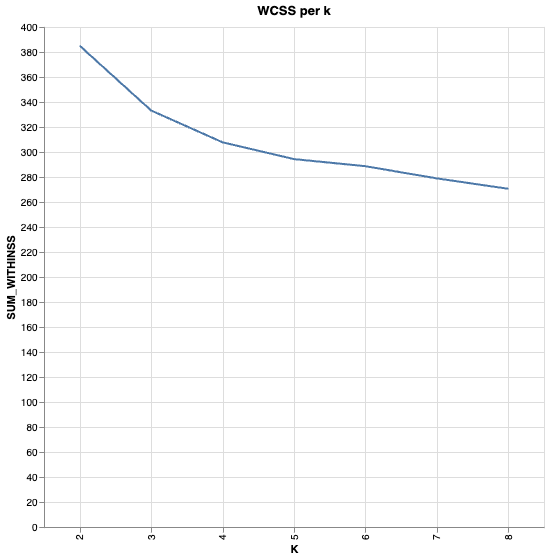

In [29]:
%chart x=K, y=SUM_WITHINSS, mark=line, height=500, width=500, title="WCSS per k"

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Conclusion</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From our simple demonstration above, we can see how data practitioners can rapidly derive powerful and unique predictive features by combining the latest AI with traditional Machine Learning <b>at scale</b>.  Furthermore, we can easily operationalize this process by combining this vector embedding and segmentation into traditional Customer 360, analytics, or additional predicitve modeling tasks - all on the same platform.</p>

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Cleanup</b></p>

In [30]:
DROP TABLE embedded_data;

Success: 0 rows affected

In [31]:
%disconnect unlimited

Success: 'unlimited' disconnected